In [1]:
import csv
import dill
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from datasets.MD17.MD17Dataset import MD17SingleDataset
from datasets.RMD17.RMD17Dataset import RMD17SingleDataset
from datasets.SMD17.SMD17Dataset import SMD17SingleDataset
from scripts.Chemistry.losses import EnergyLoss, PosForceLoss
from scripts.commom_util import *

In [2]:
def get_configs(model_path):
    configs = dict()
    with open(f"{model_path}/info.txt") as fp:
        for line in fp:
            line = line.strip().split(" ")
            if len(line)>1:
                configs[line[0]] = line[1]

    return configs

def predict(model_path, epoch, configs, device, root):
    # initialize
    if configs["dataset"]=="MD17SingleDataset":
        dataset = MD17SingleDataset(configs["style"], configs["molecule"], "test", configs["split"], root)
    elif configs["dataset"]=="SMD17SingleDataset":
        dataset = SMD17SingleDataset(configs["style"], configs["molecule"], "test", configs["split"], root)
    else:
        dataset = RMD17SingleDataset(configs["style"], configs["molecule"], "test", configs["split"], root)
    identifier = dataset.identifier
    test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=dataset.collate)
    
    path = glob.glob(f"{model_path}/{epoch:03d}_*.pth")
    if not path: raise ValueError("model not found")
    model = torch.load(path[0], map_location=torch.device(torch.cuda.current_device()), pickle_module=dill)
    print(f"Using model {path[0]}")
    model.eval()
    
    # test
    preds = []
    losses = []
    tq = tqdm(test_dataloader)
    for data, label in tq:
        data = {i:v.to(device) for i, v in data.items()}
        label = {i:v.to(device) for i, v in label.items()}
        pred = model(data)
        preds.append( ((torch.cat((pred["E"], pred["F"].reshape(1, -1)), axis=1)).squeeze()).tolist() )
     
        loss_E = (EnergyLoss(pred, label).to("cpu").item())
        loss_F = PosForceLoss(pred, label)
        loss_F = [ (l.to("cpu").item()) for l in loss_F]
        losses.append([loss_E]+loss_F)
    
    # save result
    save_reult(model_path, identifier, preds, losses)

def metric(model_path, configs, if_print=False):
    # Every dataset has different unit, unify them to Energy:eV and Force: eV/A
    toEv = {"RMD17SingleDataset":0.0433634, "MD17SingleDataset":0.0433634, "SMD17SingleDataset":0.0433634}
    ds = configs["dataset"]
    scale = toEv[configs["dataset"]]

    # load and calculate
    style, molecule, split = configs["style"], configs["molecule"], configs["split"]
    with open(f"{model_path}/loss_{ds}_{style}_{molecule}{split}test.csv", newline='') as fp:
        cdata = list(csv.reader(fp, quoting=csv.QUOTE_NONNUMERIC))
        cdata = [[c for c in row] for row in cdata]
        loss_Emole , loss_Fmole= [], []
        hit, total = 0, len(cdata)
        failE, failF = 0, 0

        #for row in tqdm(cdata):
        for row in cdata:
            loss_Emole.append(row[0]) 
            loss_Fmole.append(row[1:])
            m = max(row[1:])
            if row[0]<=0.02/scale and m<=0.03/scale: hit += 1
            else:
                if row[0]>0.02/scale: failE += 1
                if m>0.03/scale: failF += 1
        loss_Emole , loss_Fmole= np.array(loss_Emole), np.array(loss_Fmole)

        EMAE = np.mean(loss_Emole)
        FMAE = np.mean(loss_Fmole)
        EFWT = hit/total
        if if_print:
            print(f"Energy MAE: {EMAE:.3f},\tForce MAE: {FMAE:.3f},\tEFwT: {EFWT:.3f} (failE:{(failE/total):.3f}, failF:{(failF/total):.3f})\n")
        return EMAE, FMAE, EFWT

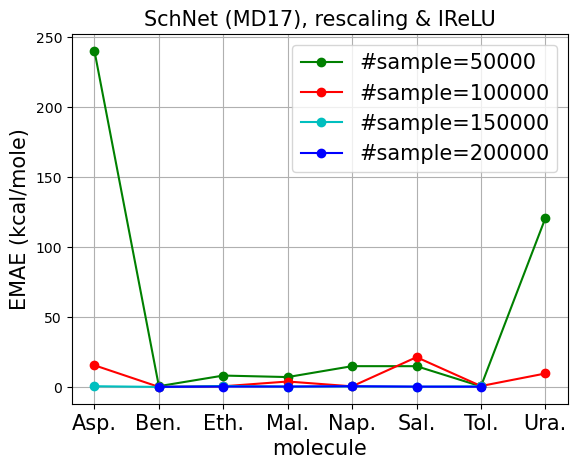

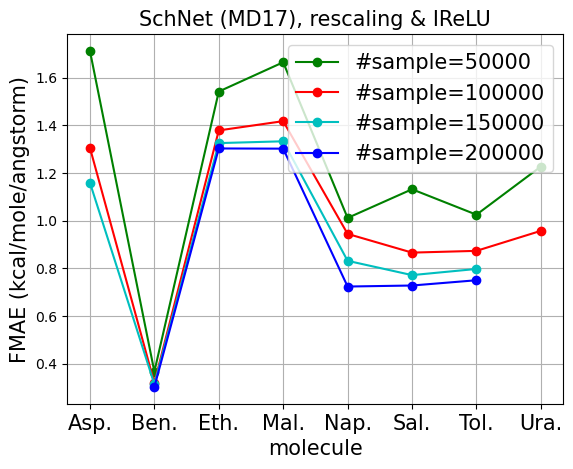

In [6]:
# Scalability test of our proposed methods 
# Model: SchNet
# Dataset: MD17

need_predict = False
EMAE_table = []
FMAE_table = []
EFWT_table = []

for num_sample in ["50000", "100000", "150000", "200000"]:
    EMAE_row = []
    FMAE_row = []
    EFWT_row = []
    
    for mole in ["a", "b", "e", "m", "n", "s", "t", "u"]:
        if (num_sample=="150000" and mole=="u") or (num_sample=="200000" and mole=="a") or (num_sample=="200000" and mole=="u"):
            EMAE_row.append(np.nan)
            FMAE_row.append(np.nan)
            EFWT_row.append(np.nan)
            continue

        model_path = f"./checkpoints/schnet_SMD{num_sample}_IR_{mole}"
        cfg = get_configs(model_path)

        if need_predict:
            root = "../../datasets/SMD17/datas"
            predict(model_path, 49, cfg, "cuda", root)
        EMAE, FMAE, EFWT = metric(model_path, cfg, if_print=False)
        EMAE_row.append(EMAE)
        FMAE_row.append(FMAE)
        EFWT_row.append(EFWT)
    
    EMAE_table.append(EMAE_row)
    FMAE_table.append(FMAE_row)
    EFWT_table.append(EFWT_row)

plt.title("SchNet (MD17), rescaling & IReLU", fontsize=15)
plt.xlabel("molecule", fontsize=15)
plt.ylabel("EMAE (kcal/mole)", fontsize=15)
plt.grid(axis='both')
plt.xticks([i for i in range(8)], ["Asp.", "Ben.", "Eth.", "Mal.", "Nap.", "Sal.", "Tol.", "Ura."], fontsize=15)

plt.plot(EMAE_table[0], "g-o", label="#sample=50000")
plt.plot(EMAE_table[1], "r-o", label="#sample=100000")
plt.plot(EMAE_table[2], "c-o", label="#sample=150000")
plt.plot(EMAE_table[3], "b-o", label="#sample=200000")

plt.legend(loc="best", fontsize=15)
plt.show()

plt.title("SchNet (MD17), rescaling & IReLU", fontsize=15)
plt.xlabel("molecule", fontsize=15)
plt.ylabel("FMAE (kcal/mole/angstorm)", fontsize=15)
plt.grid(axis='both')
plt.xticks([i for i in range(8)], ["Asp.", "Ben.", "Eth.", "Mal.", "Nap.", "Sal.", "Tol.", "Ura."], fontsize=15)

plt.plot(FMAE_table[0], "g-o", label="#sample=50000")
plt.plot(FMAE_table[1], "r-o", label="#sample=100000")
plt.plot(FMAE_table[2], "c-o", label="#sample=150000")
plt.plot(FMAE_table[3], "b-o", label="#sample=200000")

plt.legend(loc="best", fontsize=15)
plt.show()